### Test of Conv2D SVD method from Google Brain

https://www.mis.mpg.de/fileadmin/pdf/slides_lroa2019_4125.pdf



In [28]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn

alexnet = models.alexnet(pretrained=True)

layer = 8
for im, m in enumerate(alexnet.modules()):
    if im ==8:
        print(im,m)
        T = np.array(m.weight.data.clone().cpu()) 
        print(T.shape)

8 Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(384, 192, 3, 3)


In [29]:

import sys
import logging

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import powerlaw

from sklearn.decomposition import TruncatedSVD

import tensorflow as tf
from tensorflow import keras
import keras
from keras.models import load_model

class WW:

    def __init__(self, model=None, log=True, logger=None):
        self.model = self.load_model(model)
#        self.alphas = {}
        self.results = {}
        self.summary = {}
        self.logger_set(log=log, logger=logger)

        self.info(self.banner())


    def logger_set(self, log=True, logger=None):
        self.log = log
        self.logger = None
        if logger:
            self.logger = logger
        else:
            self.logger = logging.getLogger(__name__)
            if not self.logger.handlers: # do not register handlers more than once
                if log:
                    #logging.basicConfig(level=logging.DEBUG)
                    log_level = logging.INFO
                    self.logger.setLevel(log_level)
                    console_handler = logging.StreamHandler()
                    console_handler.setLevel(log_level)
                    formatter = logging.Formatter("%(asctime)s %(levelname)s %(message)s")
                    console_handler.setFormatter(formatter)
                    self.logger.addHandler(console_handler)
                else:
                    self.logger.addHandler(logging.NullHandler())


    def header(self):
        """WeightWatcher v0.1.dev0 by Calculation Consulting"""
#        from weightwatcher import __name__, __version__, __author__, __description__, __url__
#        return "{} v{} by {}\n{}\n{}".format(__name__, __version__, __author__, __description__, __url__)
        return ""

    def banner(self):
        versions  = "\npython      version {}".format(sys.version)
        versions += "\nnumpy       version {}".format(np.__version__)
        versions += "\ntensforflow version {}".format(tf.__version__)
        versions += "\nkeras       version {}".format(keras.__version__)
        return "\n{}{}".format(self.header(), versions)


    def __repr__(self):
        done = bool(self.results)
        txt  = "\nAnalysis done: {}".format(done)
        return "{}{}".format(self.header(), txt)


    def debug(self, message):
        if self.log:
            self.logger.debug(message)


    def info(self, message):
        if self.log:
            self.logger.info(message)


    def warn(self, message):
        if self.log:
            self.logger.warning(message)


    def error(self, message):
        if self.log:
            self.logger.error(message)

            
    def load_model(self, model):
        """Load a model from a file if necessary.
        """
        res = model
        if isinstance(model, str):
            if os.path.isfile(model):
                self.info("Loading model from file '{}'".format(model))
                res = load_model(model)
            else:
                self.error("Loading model from file '{}': file not found".format(model))
        return res


    def model_is_valid(self, model=None):
        model = model or self.model
        if not model:
            return False

        return True



    def get_conv2D_Wmats(self, Wtensor):
        """Extract W slices from a 4 index conv2D tensor of shape: (N,M,i,j) or (M,N,i,j).  
        Return ij (N x M) matrices

        """
        Wmats = []
        s = Wtensor.shape
        N, M, imax, jmax = s[0],s[1],s[2],s[3]
        if N + M >= imax + jmax:
            self.debug("Pytorch tensor shape detected: {}x{} (NxM), {}x{} (i,j)".format(N, M, imax, jmax))

            for i in range(imax):
                for j in range(jmax):
                    W = Wtensor[:,:,i,j]
                    if N < M:
                        W = W.T
                    Wmats.append(W)
        else:
            N, M, imax, jmax = imax, jmax, N, M          
            self.debug("Keras tensor shape detected: {}x{} (NxM), {}x{} (i,j)".format(N, M, imax, jmax))

            for i in range(imax):
                for j in range(jmax):
                    W = Wtensor[i,j,:,:]
                    if N < M:
                        W = W.T
                    Wmats.append(W)

        return Wmats

    def norm_check(self, weight, N, M, receptive_field_size, 
                   lower = 0.5, upper = 1.5):

        kappa = np.sqrt( 2 / ((N + M)*receptive_field_size) )
        norm = np.linalg.norm(weight)


        check1 = norm / np.sqrt(N*M)
        check2 = norm / (kappa*np.sqrt(N*M))
        if (check2 > lower) & (check2 < upper):   
            #aka, if Glorot normalization
            return weight / (kappa * np.sqrt(N))   
        elif (check1 > lower) & (check1 < upper): 
            return weight / np.sqrt(N)      
        else:
            return weight


    def analyze_weight_matrices(self, weights, layer_id, min_size=50, max_size=0,
                        alphas=False,  spectralnorms=False, softranks=False,
                        normalize=False,  mp_fit=False,
                        conv2Dsvd=False,  plot=False):
        """Analyzes 1 or  weight matrices (assuming all the same shape)"""


        # reset options to be consistent
        if (conv2Dsvd or mp_fit):
            alphas = True

        if (alphas or spectralnorms or softranks):
            spectralnorms = True
            softranks = True

        res = {}
        count = len(weights)
        if count == 0:
            return res

        # get an initial W and response
        # assumes all weights have the same shape
        W = weights[0]
        res[0] = {}
        
        
        
        # special case for conv2Dsvd 
        # assumes weights = [conv2D tensor] 1 matrix only
        if conv2Dsvd:  # assume W is 4-index tensor
            if len(weights)!=1:
                msg = "Only specific conv2Dsvd for 1 tensor: {}".format(len(weights))
                self.warn(msg)
                res[0]["message"] = msg
                return res
            if len(W.shape)!=4:
                msg = "Conv2D kernel wrong size: {} {}".format(W.shape, len(W.shape))
                self.warn(msg)
                res[0]["message"] = msg
                return res
        else:
            if len(W.shape)!=2:
                msg = "Weight matrix wrong size: {}".format(W.shape)
                self.warn(msg)
                res[0]["message"] = msg
                return res

        # handle special case now, save for loop later
        if conv2Dsvd:
            # is pytorch or tensor style 
            s = W.shape
            self.debug("    Conv2D SVD ({}): Analyzing ...".format(s))

            N, M, imax, jmax = s[0],s[1],s[2],s[3]
            # probably better just to check what col N is in 
            shape_type = "pytorch"
            if N + M >= imax + jmax:
                self.debug("Pytorch tensor shape detected: {}x{} (NxM), {}x{} (i,j)".format(N, M, imax, jmax))    
                fft_axes = [2,3]
            else:
                N, M, imax, jmax = imax, jmax, N, M          
                shape_type = "keras"
                fft_axes = [0,1]
                self.debug("Keras tensor shape detected: {}x{} (NxM), {}x{} (i,j)".format(N, M, imax, jmax))

            #  receptive_field / kernel size
            rf = np.min([imax, jmax])
            # aspect ratio
            Q = N/M 
            # num non-zero eigenvalues
            n_comp = rf*N*M

            # run FFT on each channel
            fft_grid = [32,32]
            fft_coefs = np.fft.fft2(W, fft_grid, axes=fft_axes)
            # bug in svd, can not compute complex values
            #svd = TruncatedSVD(n_components=n_comp, n_iter=7, random_state=10)
            #svd.fit(fft_coefs)
            #sv = svd.singular_values_
            sv = np.linalg.svd(fft_coefs, compute_uv=False).flatten()
            sv = np.sort(sv)[-n_comp:]
            evals = sv*sv
            frobenius_norm = np.sqrt(np.sum(evals))

        elif stack_slices:
            # this should be part of get_conv2Dmats
            # replace weights with W
            self.debug("stack slices N/A yet")        
            evals = None
        elif merge_slices:
            # compute all evals, merge
            # really only for conv2D
            # replace weights with W
            self.debug("merge slices N/A yet")
            evals = None
        else:
            s = W.shape
            N, M = np.max(s), np.min(s)
            # aspect ratio
            Q = N/M 
            evals = None

            if M < min_size:
                summary = "Weight matrices too small {}  Skipping: (<{})".format(W.shape, min_size)
                res[0]["summary"] = summary 
                self.info("    {}".format(summary))
                return res

            if max_size > 0 and M > max_size:
                summary = "Weight matrices too large {}  Skipping:  (>{})".format(W.shape, max_size)
                res[0]["summary"] = summary 
                self.info("    {}".format(summary))
                return res

        # loop over all slices
        for i, W in enumerate(weights):
            res[i] = {}
            res[i]["N"] = N
            res[i]["M"] = M
            res[i]["Q"] = Q

            summary = []
            self.debug("    Weight matrix {} {}/{} ({},{}): Analyzing ...".format(layer_id, i+1, count, M, N))

            if alphas:
                if evals is None: 
                    sv = np.linalg.svd(W,  compute_uv=False())
                    evals = sv*sv/N
                    frobenius_norm = np.linalg.norm(W)

                lambda_min, lambda_max = np.min(evals), np.max(evals)
                fit = powerlaw.Fit(evals, xmax=lambda_max, verbose=False)
                alpha = fit.alpha 
                D = fit.D

                alpha_weighted = alpha * np.log10(lambda_max)
                log_pnorm = np.log10(np.sum([ev**alpha for ev in evals]))

                res[i]["alpha"] = alpha
                res[i]["D"] = D
                res[i]["alpha_weighted"] = alpha_weighted


            if spectralnorms:  # always set if alphas set
                if evals is None:
                    svd = TruncatedSVD(n_components=1, n_iter=7, random_state=10)
                    svd.fit(fft_coefs)
                    evals = sv*sv/N
                    frobenius_norm = np.linalg.norm(W)    
                    # check evals / norm

                lambda_min, lambda_max = np.min(evals), np.max(evals)
                spectral_norm = np.max(evals)

                res[i]["lambda_max"] = lambda_max
                res[i]["lambda_min"] = lambda_min
                res[i]["spectral_norm"] = spectral_norm
                res[i]["spectral_normlog"] = np.log10(spectral_norm)


                # soft rank =  stable rank
                softrank = (frobenius_norm**2) / spectral_norm
                softranklog = np.log10(softrank)
                softranklogratio = 2*np.log10(frobenius_norm) / np.log10(spectral_norm)

                res[i]["softrank"] = softrank
                res[i]["softranklog"] = softranklog
                res[i]["softranklogratio"] = softranklogratio


            # computations for all W
            res[i]["norm"] = frobenius_norm
            res[i]["lognorm"] = np.log10(frobenius_norm)

            tolerance = lambda_max * M * np.finfo(np.max(sv)).eps
            res[i]["rank_loss"] = np.count_nonzero(sv > tolerance, axis=-1)


            if plot:
                a = "{:2f}".format(alpha)
                plt.hist(np.log10(evals),bins=100, label=a);
                plt.title("AlexNet Layer {} W Log10 Eigenvales \n Conv2D-SVD FFT approach".format(layer_id))
               
                plt.xlabel(r"$\rho(\log_{10}\lambda)$")
                plt.legend()
                plt.show()

            #        if mp_fit:
            #            do_mp_fit(N,M,Q,evals,sv)

            # reset computations
            evals = None
        return res



In [30]:
ww = WW()

2020-01-02 15:27:03,965 INFO 

python      version 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy       version 1.16.4
tensforflow version 1.13.1
keras       version 2.2.4


2 Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))


/Users/charleshmartin/anaconda3/lib/python3.7/site-packages/powerlaw.py:1178: RuntimeWarning: overflow encountered in double_scalars
  return (self.alpha-1) * self.xmin**(self.alpha-1)
/Users/charleshmartin/anaconda3/lib/python3.7/site-packages/powerlaw.py:825: RuntimeWarning: invalid value encountered in multiply
  likelihoods = f*C


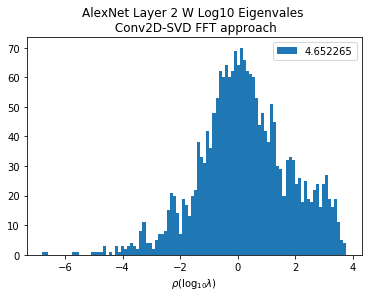

5 Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))


In [ ]:
for im, m in enumerate(alexnet.modules()):
    if  im > 1 and "Conv2d" in str(m):
        print(im,m)
        W = np.array(m.weight.data.clone().cpu()) 
        results = ww.analyze_weight_matrices([W], layer_id=im, conv2Dsvd=True, plot=True)